In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

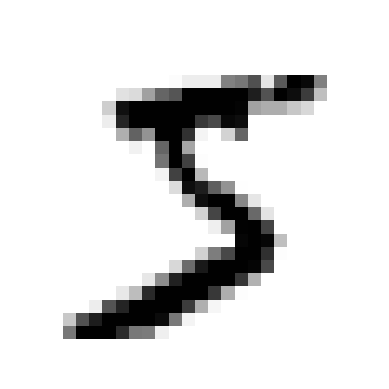

In [7]:
# 이미지 하나 확인하기
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [9]:
# train set과 test set 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

In [10]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
# 확률적 경사 하강법 사용
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차 검증(정확도 이용)

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
# 모든 이미지를 5가 아닌 것으로 분류하면 성능이 어떻게 될까?
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

### 오차 행렬과 정밀도, 재현율

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
# 완벽한 분류기의 오차행렬
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [20]:
# 정밀도와 재현율 구현
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
# F1 점수
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [23]:
# 임곗값 확인
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
# 임곗값 지정
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
# 적절한 임곗값 정하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [27]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

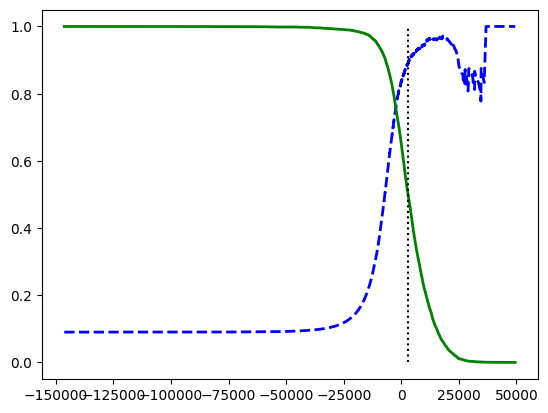

In [28]:
# 임곗값에 대한 정밀도와 재현율
plt.plot(thresholds, precisions[:-1], 'b--', label='precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, 'k', 'dotted', label='threshold')
plt.show()

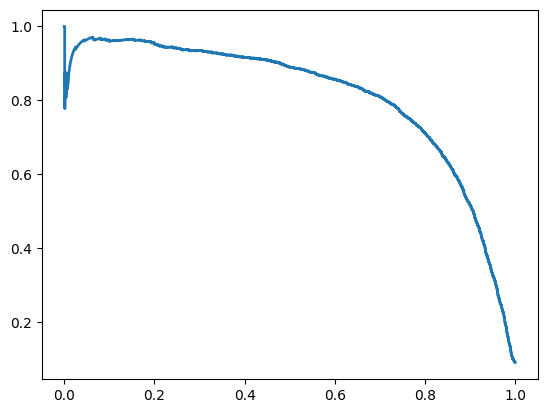

In [30]:
# 재현율에 대한 정밀도 곡선
plt.plot(recalls, precisions, linewidth=2, label='precision/recall curve')
plt.show()

In [31]:
# 정밀도가 최소 90%가 되는 가장 낮은 임곗값 찾기
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [32]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [34]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### ROC 곡선

In [35]:
# 진짜 양성 비율(TPR), 1-진짜 음성 비율(FPR) 계산
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

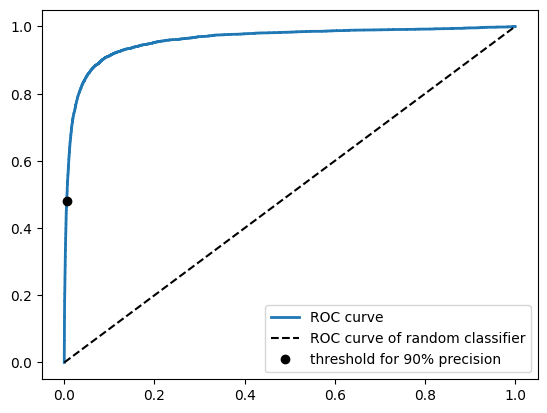

In [38]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='ROC curve of random classifier')
plt.plot([fpr_90], [tpr_90], 'ko', label='threshold for 90% precision')
plt.legend()
plt.show()

In [40]:
# 곡선 아래 면적(AUC)으로 분류기 비교
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### 랜덤포레스트 분류기와 비교

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [42]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [43]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [44]:
# 두 번째 열에 양수 클래스에 대한 확률이 있으므로 이를 전달
y_scores_forest = y_probas_forest[:, 1]
precision_forest, recall_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

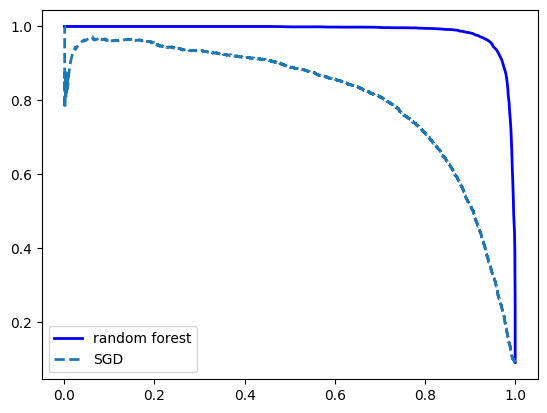

In [45]:
plt.plot(recall_forest, precision_forest, 'b-', linewidth=2, label='random forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.legend()
plt.show()

In [47]:
# F1 점수, ROC 및 AUC 점수도 비교하자.
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145